Data preprocessing :
<br>
Two data sources will be imported <br>
-"AIS_weather_h_rename_copy.csv" will be used to replace the information for true current direction and true wind direction <br>
-The resulting dataframe will be merged with the dataframe from the "AIS_weather_H_ok2_copy.csv" <br>
-The data of the journey between Ronne and Sassnitz will be omitted <br>
-The threshold for the ships manouvering speed will be 5kt (Abebe) <br>

In [526]:
import pandas as pd
from matplotlib import pyplot
import numpy as np
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime
import pickle
import joblib

dfmain = pd.read_csv("AIS_weather_H_ok2_copy.csv",parse_dates=["Time"])
dfmain = dfmain[dfmain['LAT'] > 55.04 ]

dfpre = pd.read_csv("AIS_weather_h_rename_copy.csv",parse_dates=["Time"])
dfpre = dfpre[dfpre['LAT'] > 55.04 ]



In [527]:
dfpre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7453 entries, 0 to 7995
Data columns (total 27 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Time                                  7453 non-null   datetime64[ns]
 1   LON                                   7453 non-null   float64       
 2   LAT                                   7453 non-null   float64       
 3   Eastward wind                         7453 non-null   float64       
 4   Northward wind                        7453 non-null   float64       
 5   Temperature above oceans              7453 non-null   float64       
 6   Air density above oceans              7337 non-null   float64       
 7   Max wave height                       6274 non-null   float64       
 8   Swell direction                       6274 non-null   float64       
 9   Wind wave direction                   6274 non-null   float64       
 10  

In [528]:
dfpre = dfpre.drop(dfpre.columns[[0,1,2,5,6,7,8,9,10,11,12,13,14,15,16,17,18,21,22,23,26]],axis=1)
dfpre = dfpre.rename({'Eastward wind': 'eastwind', 'Northward wind': 'northwind',
                           'Eastward current': 'eastcurrent', 'Northward current': 'northcurrent',
                           'SOG':'sog','COG':'cog','Heading':'heading'},axis=1) 
dfpre.head(n=5)

,eastwind,northwind,eastcurrent,northcurrent,sog,cog
0,2.267688,6.741482,0.113690,0.044994,0.0,358.9
1,1.782681,6.410275,0.113690,0.044994,0.0,358.9
2,1.154659,6.385135,0.083984,0.054000,0.0,358.9
3,0.348801,6.094659,0.083984,0.054000,0.0,358.9
4,-0.593128,6.153186,0.083984,0.054000,0.0,358.9


In [529]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)
imputer.fit(dfpre)

KNNImputer(n_neighbors=50)

In [530]:
x_pre = imputer.transform(dfpre)

In [531]:
dfpre = pd.DataFrame(x_pre, columns=dfpre.columns, index=dfpre.index)

In [ ]:
dfpre["Current Speed"] = np.sqrt(dfpre["eastcurrent"]**2 + dfpre["northcurrent"]**2)
dfpre["Wind Speed"] = np.sqrt(dfpre["eastwind"]**2 + dfpre["northwind"]**2)

In [ ]:
dfpre["True North Wind Direction"] = 180 +  np.rad2deg(np.arctan(dfpre["eastwind"]/dfpre["northwind"]))

In [ ]:
dfpre["True North Current Direction"] = np.rad2deg(np.arctan(dfpre["eastcurrent"]/dfpre["northcurrent"]))

In [ ]:
dfpre.describe()

,eastwind,northwind,eastcurrent,northcurrent,sog,cog,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
count,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000,7453.000000
mean,1.976344,0.379926,0.019228,0.004214,8.870751,242.699284,0.096788,6.513813,186.323949,-0.733565
std,5.296850,4.429899,0.089903,0.074041,8.619512,108.555287,0.067697,3.048934,56.940496,57.865151
min,-15.216397,-12.824582,-0.491010,-0.404690,-0.009130,-0.134241,0.000735,0.193221,90.038520,-89.957853
25%,-1.756650,-2.534061,-0.021486,-0.033055,0.000000,124.116508,0.047447,4.149883,133.386049,-55.497208
50%,2.294543,0.385690,0.025485,0.003718,6.953578,283.216008,0.079148,6.285080,192.348882,-1.876044
75%,5.838650,3.339456,0.062644,0.039626,18.014436,346.200000,0.128444,8.525129,239.985376,54.717045
max,16.338177,14.519458,0.522374,0.364966,21.070514,359.728115,0.525174,16.760001,269.907884,89.975398


In [ ]:
dfpre = dfpre.drop(['eastwind','northwind','eastcurrent','northcurrent','sog','cog'],axis=1)

In [ ]:
dfmain = dfmain.drop(['Wind Speed','Current Speed'],axis=1)

In [ ]:
df = pd.concat([dfmain,dfpre],axis=1)
df.head()

,Unnamed: 0,Time,LON,LAT,Temperature above oceans,Air density above oceans,Max wave height,Swell period,Wind wave period,Wave period,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
0,0,2021-01-01 00:00:00,14.689663,55.098452,277.311035,1.259323,1.893614,4.818881,3.818459,4.154329,...,174.0,155.408180,105.591753,22.854050,22.749664,22.610062,0.122270,7.112664,198.591820,68.408246
1,1,2021-01-01 01:00:00,14.689659,55.098451,277.328369,1.259985,1.752303,4.755800,3.470216,4.130580,...,174.0,158.458891,105.591753,26.122772,19.152008,22.209274,0.122270,6.653538,195.541109,68.408246
2,2,2021-01-01 02:00:00,14.689648,55.098468,277.390625,1.260244,1.619775,4.645083,3.259682,4.083755,...,174.0,163.749663,116.740448,28.498383,12.424912,20.857971,0.099846,6.488697,190.250337,57.259552
3,3,2021-01-01 03:00:00,14.689646,55.098471,277.411377,1.260148,1.518736,4.588384,3.177906,4.010502,...,174.0,170.724504,116.740448,29.956985,6.725922,18.732071,0.099846,6.104632,183.275496,57.259552
4,4,2021-01-01 04:00:00,14.689644,55.098462,277.430664,1.260634,1.455034,4.528841,3.281654,3.913362,...,174.0,179.505940,116.740448,34.486298,3.761627,15.731430,0.099846,6.181707,174.494060,57.259552


In [ ]:
# SOG threshold according to Abebe
df = df[df['SOG'] > 5 ]

In [ ]:
# Exclude data for the month of June to check the model's forecasting performance 
dfdate6 = df[df['Time'].dt.strftime('%Y-%m') == '2021-06']
df = df[df['Time'].dt.strftime('%Y-%m') != '2021-06']

In [ ]:
# Temporary export
# df.to_csv("AIS_sog_threshold.csv")

In [ ]:
# Temporary export
# df.to_csv("AIS_impute_check.csv")

Data Analysis before modelling 

In [ ]:
df_ship = df.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
                    'Surface pressure','Width','Length'],axis=1)
df_ship.head(n=5)

,Temperature above oceans,Max wave height,Swell period,Wind wave period,Wave period,Sea surface temperature,Combined wind waves and swell height,Swell height,Wind wave height,Draught,...,Heading,True Wind Direction,True Current Direction,True Swell Direction,True Wind Wave Direction,True Wave Direction,Current Speed,Wind Speed,True North Wind Direction,True North Current Direction
8,276.900391,1.661038,4.291309,3.667458,3.757862,279.699585,0.865413,0.323892,0.801956,5.017723,...,269.900574,91.133175,143.029898,82.454986,91.138748,90.495209,0.104064,7.648595,181.033749,52.930471
9,276.705566,1.501637,4.187211,3.145607,3.803910,279.820312,0.785675,0.452440,0.578049,5.019207,...,300.130435,68.884377,96.351303,134.548587,115.015200,120.971331,0.104050,6.700397,189.014812,36.481737
10,276.309815,1.235528,4.012717,2.120399,3.819602,NaN,0.654636,0.556525,0.236435,5.019664,...,230.117302,129.989203,174.697284,59.296837,47.905998,52.498604,0.092759,4.089472,180.106505,44.814586
11,276.399902,1.204397,4.020009,2.090308,3.820546,NaN,0.638782,0.555405,0.226181,5.019009,...,178.653615,170.879672,107.951765,8.221531,10.314571,1.236454,0.093128,3.821501,187.773943,70.701850
12,277.134033,1.275907,4.095175,3.029945,3.815268,279.820312,0.674081,0.598373,0.263031,5.020452,...,125.446296,102.327505,72.665715,47.977150,68.470208,54.270195,0.086621,5.479353,203.118792,52.780582


In [ ]:
df_ship2 = df_ship.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
                           'SOG': 'sog', 'Wind Speed': 'windspeed', 
                           'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
                           'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
                            'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
                            'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
                            'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
                            'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
                            'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
                           }, axis=1) 

In [ ]:
# Scaling script if necessary

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# df_ship2 = pd.DataFrame(scaler.fit_transform(df_ship2),columns=df_ship2.columns)


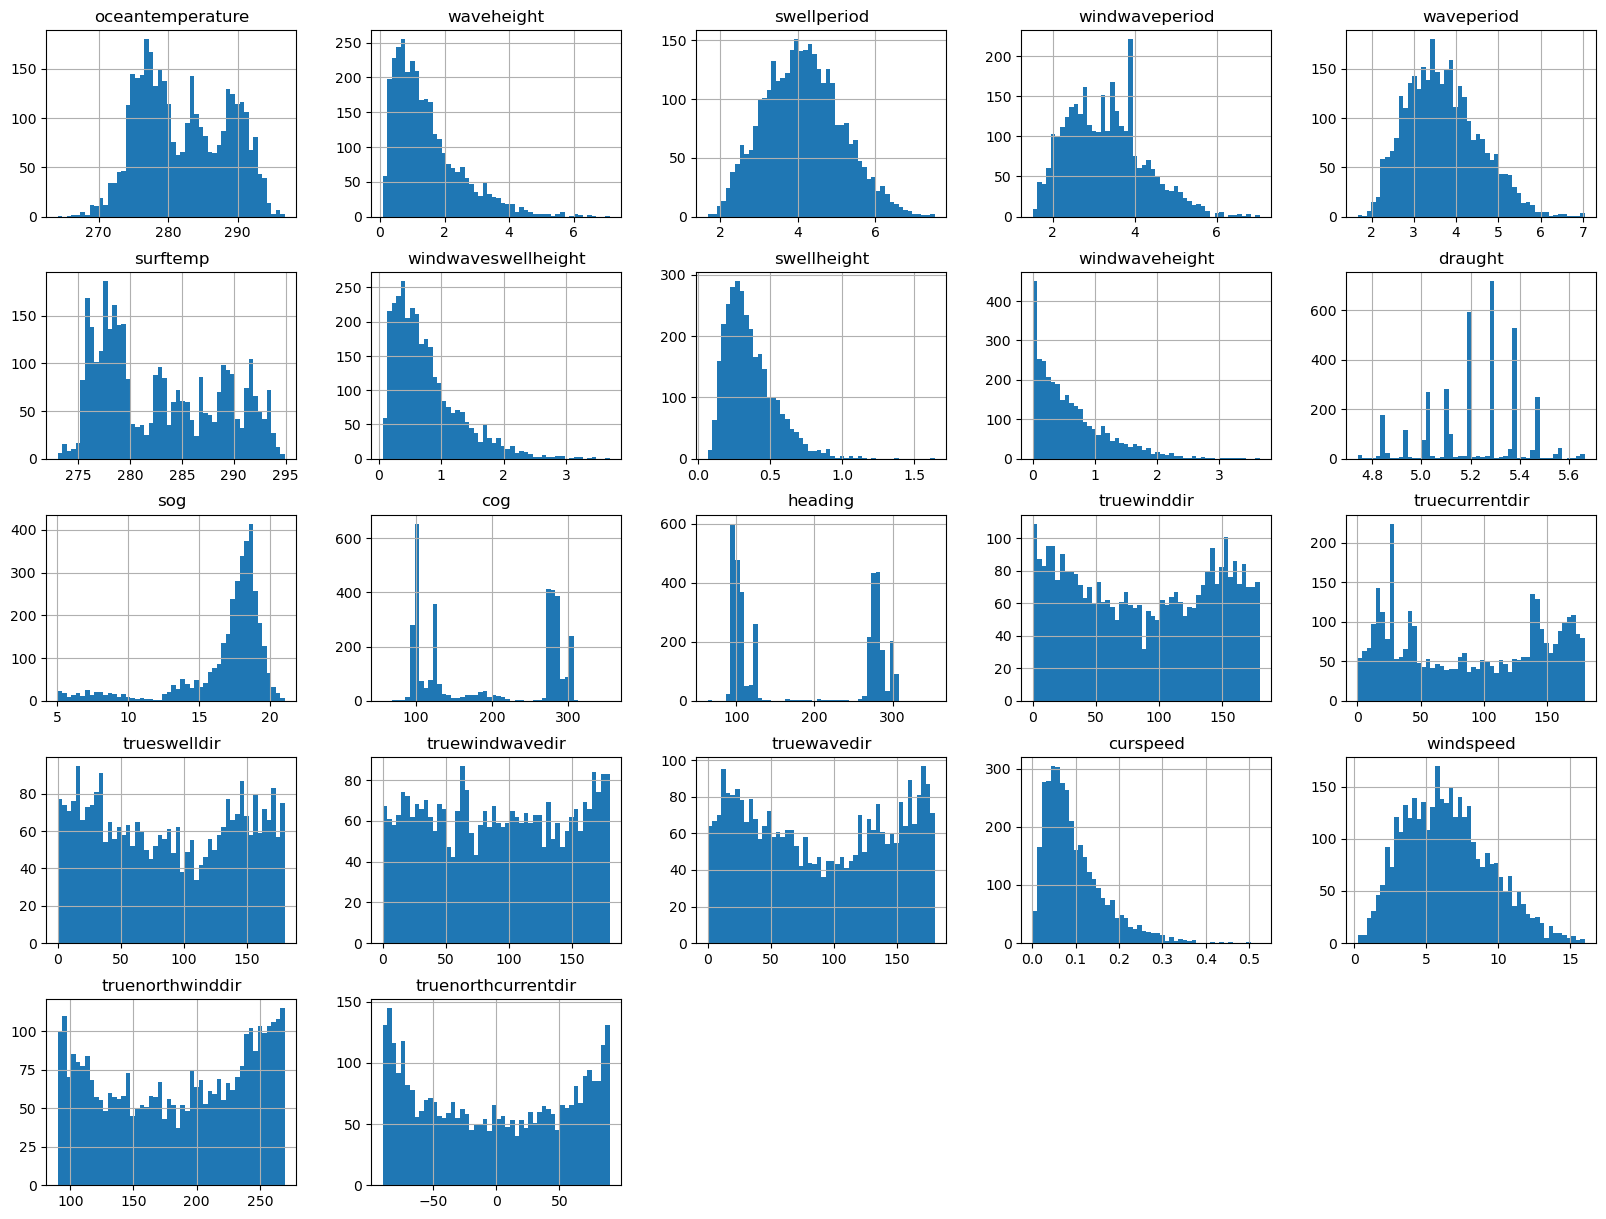

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
df_ship2.hist(bins=50,figsize=(20,15))
plt.show()

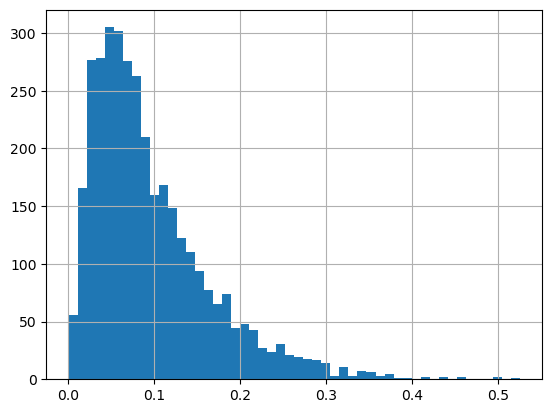

In [ ]:
df_ship2['curspeed'].hist(bins=50)
plt.show()

In [ ]:
hhstats = df_ship2.describe()
print(hhstats)

       oceantemperature   waveheight  swellperiod  windwaveperiod  \
count       3506.000000  3152.000000  3152.000000     3152.000000   
mean         282.187439     1.457923     4.140942        3.299684   
std            6.345629     1.052465     0.991532        0.939149   
min          264.076782     0.083379     1.681843        1.517006   
25%          276.908691     0.671875     3.416050        2.559944   
50%          281.418823     1.180761     4.102280        3.239967   
75%          288.072144     1.928374     4.810565        3.864906   
max          296.830322     7.120887     7.531564        7.052921   

        waveperiod     surftemp  windwaveswellheight  swellheight  \
count  3152.000000  3391.000000          3152.000000  3152.000000   
mean      3.698114   283.014106             0.766249     0.359745   
std       0.862321     5.765232             0.538023     0.175846   
min       1.672565   273.048584             0.065236     0.065332   
25%       3.049094   277.872803  

Feature Selection

In [ ]:
corr_matrix = df_ship2.corr()
print(corr_matrix["sog"])

oceantemperature       0.066226
waveheight            -0.004305
swellperiod           -0.001119
windwaveperiod        -0.013876
waveperiod             0.002105
surftemp               0.031413
windwaveswellheight   -0.003199
swellheight           -0.020481
windwaveheight        -0.000675
draught                0.148754
sog                    1.000000
cog                    0.016333
heading                0.213539
truewinddir            0.063382
truecurrentdir         0.147950
trueswelldir           0.001415
truewindwavedir       -0.003321
truewavedir           -0.006828
curspeed               0.137821
windspeed              0.117765
truenorthwinddir       0.011171
truenorthcurrentdir    0.013469
Name: sog, dtype: float64


In [ ]:
dfship_corr = df_ship2.drop(df_ship2.columns[[0,5,15,16,17,18,19,20,21]],axis=1)
dfship_corr.head()

,waveheight,swellperiod,windwaveperiod,waveperiod,windwaveswellheight,swellheight,windwaveheight,draught,sog,cog,heading,truewinddir,truecurrentdir
8,1.661038,4.291309,3.667458,3.757862,0.865413,0.323892,0.801956,5.017723,14.578394,299.573513,269.900574,91.133175,143.029898
9,1.501637,4.187211,3.145607,3.803910,0.785675,0.452440,0.578049,5.019207,18.148696,302.274508,300.130435,68.884377,96.351303
10,1.235528,4.012717,2.120399,3.819602,0.654636,0.556525,0.236435,5.019664,9.686510,163.922318,230.117302,129.989203,174.697284
11,1.204397,4.020009,2.090308,3.820546,0.638782,0.555405,0.226181,5.019009,11.252112,117.003285,178.653615,170.879672,107.951765
12,1.275907,4.095175,3.029945,3.815268,0.674081,0.598373,0.263031,5.020452,18.119627,125.829385,125.446296,102.327505,72.665715


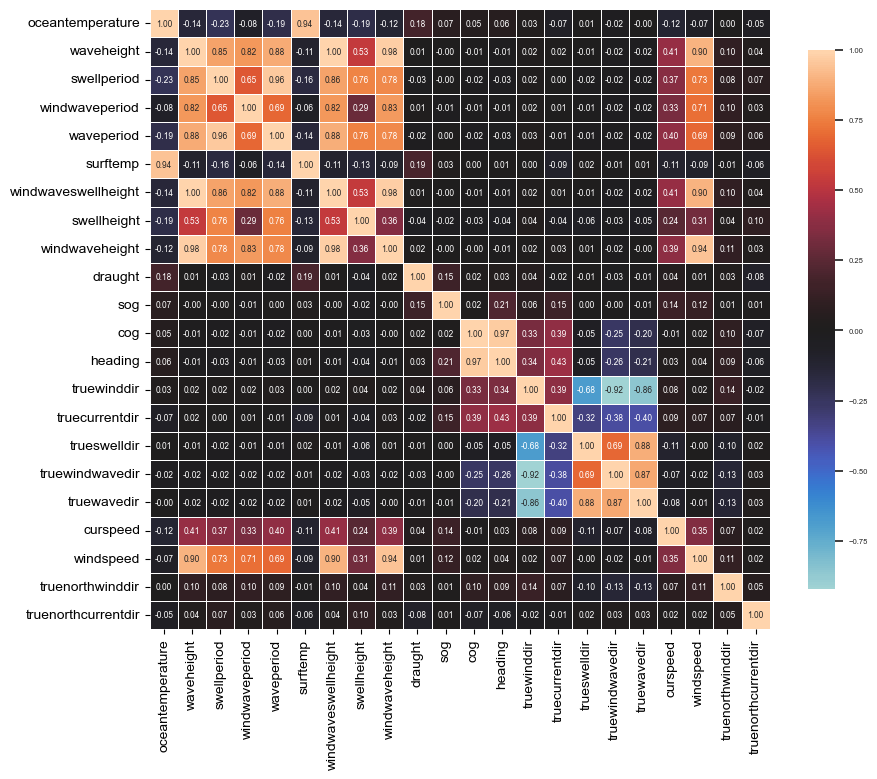

In [ ]:
def correlation_heatmap(df,fontsize):
    correlations = df.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.set(font_scale = fontsize)
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();
    
correlation_heatmap(df_ship2,0.5)

Scientific Justification of HCF:

According to Bitner Gregersen, the wind wave swell height is equal to the square root of the square of swell wave and wind wave. Therefore SWH and WWH is to be dropped.<br>
According to Mori, through wave spectrum, the maximum wave height can be approximated, therefore max wave height can be dropped as well 

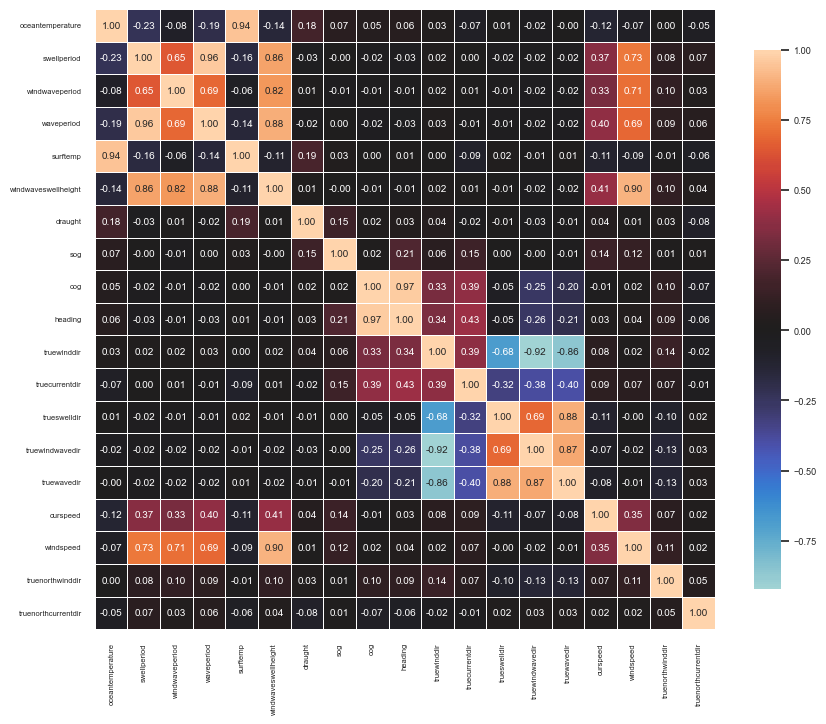

In [ ]:
df_ship2 = df_ship2.drop(['waveheight','swellheight','windwaveheight'],axis=1)

correlation_heatmap(df_ship2,.6)

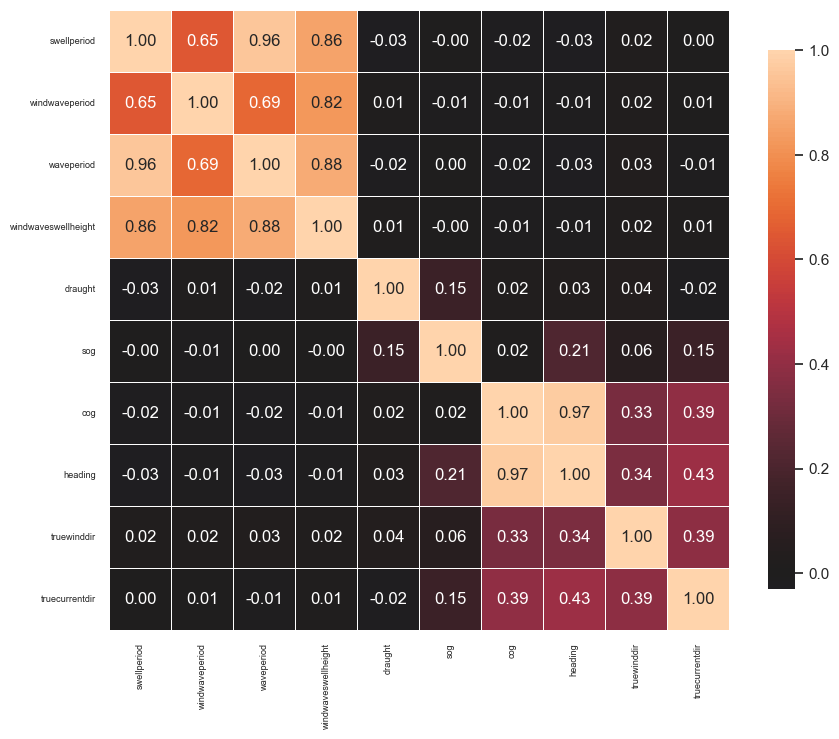

In [ ]:
dfship_corrftf = dfship_corr.drop(['waveheight','swellheight','windwaveheight'],axis=1)

correlation_heatmap(dfship_corrftf,1)

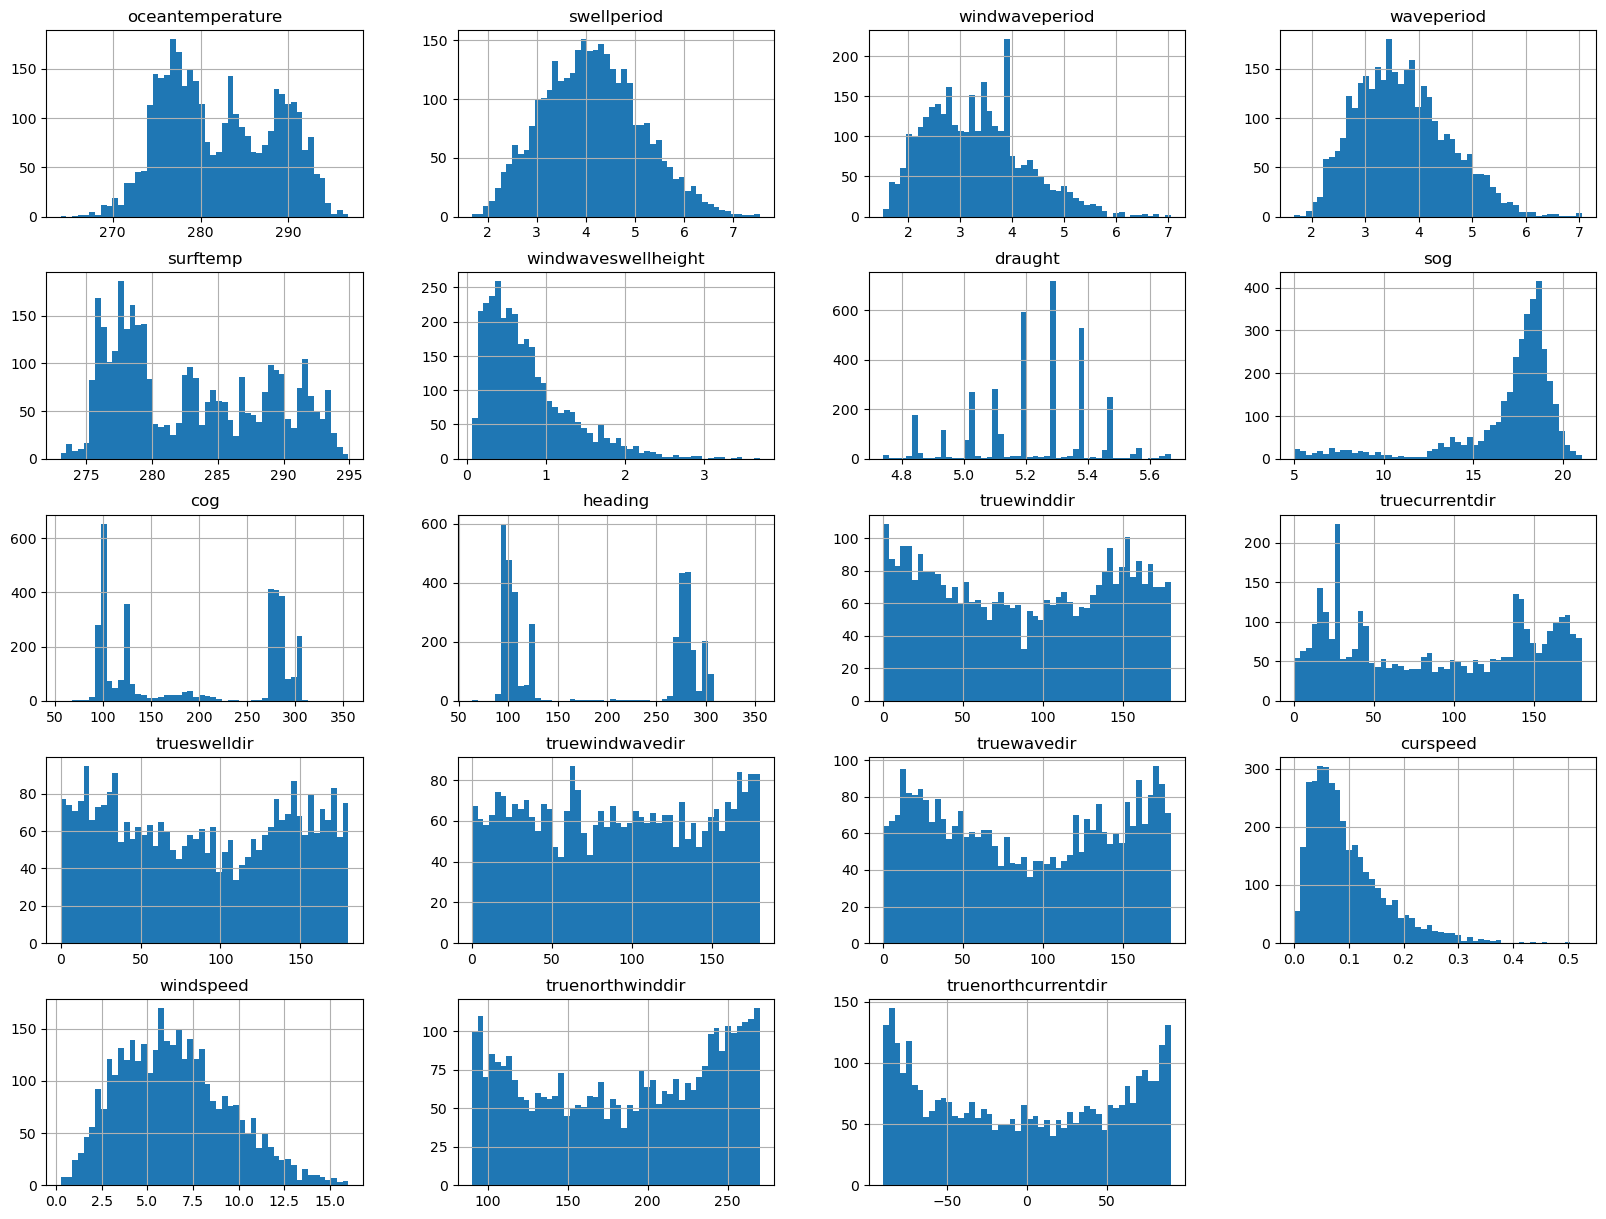

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
df_ship2.hist(bins=50,figsize=(20,15))
plt.show()

In [ ]:
# from pandas.plotting import scatter_matrix

# # attributes = df_ship2.columns

# scatter_matrix(dfship_corrftf,figsize=(25,25))

In [ ]:
df_ship2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3506 entries, 8 to 7976
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   oceantemperature     3506 non-null   float64
 1   swellperiod          3152 non-null   float64
 2   windwaveperiod       3152 non-null   float64
 3   waveperiod           3152 non-null   float64
 4   surftemp             3391 non-null   float64
 5   windwaveswellheight  3152 non-null   float64
 6   draught              3506 non-null   float64
 7   sog                  3506 non-null   float64
 8   cog                  3506 non-null   float64
 9   heading              3506 non-null   float64
 10  truewinddir          3506 non-null   float64
 11  truecurrentdir       3506 non-null   float64
 12  trueswelldir         3152 non-null   float64
 13  truewindwavedir      3152 non-null   float64
 14  truewavedir          3152 non-null   float64
 15  curspeed             3506 non-null   f

Imputing using KNN so that the Random Forest Regressor may function <br>
RFR cannot accept nan values <br>
Imputed data is then transformed

In [ ]:
import numpy as np
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=50)
imputer.fit(df_ship2)


KNNImputer(n_neighbors=50)

In [ ]:
X = imputer.transform(df_ship2)

In [ ]:
df_ship2tr = pd.DataFrame(X, columns=df_ship2.columns, index=df_ship2.index)

In [ ]:
print(df_ship2tr.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3506 entries, 8 to 7976
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   oceantemperature     3506 non-null   float64
 1   swellperiod          3506 non-null   float64
 2   windwaveperiod       3506 non-null   float64
 3   waveperiod           3506 non-null   float64
 4   surftemp             3506 non-null   float64
 5   windwaveswellheight  3506 non-null   float64
 6   draught              3506 non-null   float64
 7   sog                  3506 non-null   float64
 8   cog                  3506 non-null   float64
 9   heading              3506 non-null   float64
 10  truewinddir          3506 non-null   float64
 11  truecurrentdir       3506 non-null   float64
 12  trueswelldir         3506 non-null   float64
 13  truewindwavedir      3506 non-null   float64
 14  truewavedir          3506 non-null   float64
 15  curspeed             3506 non-null   f

Data Split for training and test data

In [ ]:
# Implement the Random forest, but first, data is to be split into training and validation data

from sklearn.model_selection import train_test_split

# Dropping some feature can be done here to (possibly) increase the model's performance 

x_train,x_test,y_train,y_test = train_test_split(df_ship2tr.drop(['sog','truenorthcurrentdir','truenorthwinddir']
                                                                 ,axis=1)
                                                                ,df_ship2tr.sog,test_size=0.2,random_state=42)


In [ ]:
print("Amount of the x training dataset is:",len(x_train))

Amount of the x training dataset is: 2804


In [ ]:
print("Amount of the test dataset is",len(x_test))

Amount of the test dataset is 702


Modelling using Random Forest Regressor 

In [ ]:
from sklearn.ensemble import RandomForestRegressor
model_rfr = RandomForestRegressor()
model_rfr.fit(x_train,y_train)

RandomForestRegressor()

Modelling using Decision Tree Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor
model_dtr = DecisionTreeRegressor()
model_dtr.fit(x_train,y_train)

DecisionTreeRegressor()

Modelling using Multiple Linear Regression

In [ ]:
from sklearn import linear_model
model_mlr = linear_model.LinearRegression()
model_mlr.fit(x_train,y_train)

LinearRegression()

Model Evaluation

In [ ]:
from sklearn import tree

def tree_visualization(width,height,model_type):
    fn=x_train.columns
    fig, axes = plt.subplots(figsize = (width,height), dpi=800)
    tree.plot_tree(model_type.estimators_[0],
               max_depth=3,
               fontsize=8,
               feature_names = fn);
    plt.show()
    #fig.savefig('rf_individualtree.png')

tree_visualization(25,5,model_rfr)

In [ ]:
def model_importance(model_type):
    mod_imp = model_type.feature_importances_
    df_mod_imp = pd.DataFrame(mod_imp,index= x_train.columns,columns=["Importance"])
    print(df_mod_imp)

model_importance(model_rfr)

                     Importance
oceantemperature       0.004589
swellperiod            0.004249
windwaveperiod         0.006115
waveperiod             0.003579
surftemp               0.005517
windwaveswellheight    0.003891
draught                0.021961
cog                    0.426793
heading                0.490827
truewinddir            0.003568
truecurrentdir         0.006259
trueswelldir           0.005797
truewindwavedir        0.003867
truewavedir            0.003248
curspeed               0.005925
windspeed              0.003814


Evaluation of RFR

In [ ]:
def predict_y(x_test,model_type):
    y_predicted = model_type.predict(x_test)
    return y_predicted

def display_scores(x_test,y_test,model_type):
    from sklearn.metrics import explained_variance_score,mean_absolute_error,mean_squared_error,median_absolute_error
    y_predicted = model_type.predict(x_test)
    print("R^2 score (Indicate model fit. Best Score = 1):", model_type.score(x_test,y_test))
    print("Explained Variance EV (Indicate amount of variance in model. Best Score = 1):", explained_variance_score(y_test,y_predicted))
    print("Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0):", mean_absolute_error(y_test,y_predicted))
    print("Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0):", mean_squared_error(y_test,y_predicted))
    print("Median Absolute Error MAD (Check robustness against outlier. Best Score = 1):", median_absolute_error(y_test,y_predicted))

y_predicted = predict_y(x_test,model_rfr)
display_scores(x_test,y_test,model_rfr)


R^2 score (Indicate model fit. Best Score = 1): 0.933074146129249
Explained Variance EV (Indicate amount of variance in model. Best Score = 1): 0.933125813907918
Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0): 0.5553310948229913
Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0): 0.7068442993249482
Median Absolute Error MAD (Check robustness against outlier. Best Score = 1): 0.3919353783299995


Evaluation of DTR

In [ ]:
y_predicted = predict_y(x_test,model_dtr)
display_scores(x_test,y_test,model_dtr)

R^2 score (Indicate model fit. Best Score = 1): 0.8483111387568871
Explained Variance EV (Indicate amount of variance in model. Best Score = 1): 0.8485634953675913
Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0): 0.8355948125897436
Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0): 1.602077532665543
Median Absolute Error MAD (Check robustness against outlier. Best Score = 1): 0.5655161500000006


Evaluation of MLR 

In [ ]:
y_predicted = predict_y(x_test,model_mlr)
display_scores(x_test,y_test,model_mlr)

R^2 score (Indicate model fit. Best Score = 1): 0.6917131294875135
Explained Variance EV (Indicate amount of variance in model. Best Score = 1): 0.692003928717865
Mean Absolute Error MAE (Indicate how much error a model makes in its prediction. Best Score = 0): 1.1412579894343058
Root Mean Square Error RMSE (Same as MAE, more sensitive to outlier. Best Score = 0): 3.2560035378751366
Median Absolute Error MAD (Check robustness against outlier. Best Score = 1): 0.8971795618465439


In [ ]:
cdf = pd.DataFrame(model_mlr.coef_, x_test.columns, columns=['Coefficients'])
print(cdf)

                     Coefficients
oceantemperature         0.050174
swellperiod             -0.091387
windwaveperiod          -0.040738
waveperiod               0.610479
surftemp                -0.055334
windwaveswellheight     -1.048962
draught                  2.079308
cog                     -0.115465
heading                  0.115999
truewinddir              0.000887
truecurrentdir          -0.000291
trueswelldir             0.002056
truewindwavedir          0.003890
truewavedir             -0.003954
curspeed                -0.608641
windspeed                0.106828


Saving model to local directory

In [ ]:
# Saving the model to local directory

# filename = 'savemodel_rfr.sav'
# joblib.dump(model_rfr,filename)

# filename = 'savemodel_dtr.sav'
# joblib.dump(model_dtr,filename)

Forecasting for June 2021

In [ ]:
# dfdate6 = dfdate6.drop(['Unnamed: 0','Time','LON','LAT','Air density above oceans',
# 'Surface pressure','Width','Length'],axis=1)
# dfdate6.head(n=5)

In [ ]:
# dfdate6= dfdate6.rename({'Max wave height': 'waveheight', 'Draught': 'draught',
#                            'SOG': 'sog', 'Wind Speed': 'windspeed', 
#                            'True Wind Direction': 'truewinddir','Temperature above oceans' : 'oceantemperature',
#                            'COG': 'cog', 'Current Speed' : 'curspeed','True Wave Direction' : 'truewavedir',
#                             'Swell period': 'swellperiod','Wind wave period': 'windwaveperiod','Sea surface temperature': 'surftemp',
#                             'Combined wind waves and swell height': 'windwaveswellheight','Swell height': 'swellheight','Wind wave height': 'windwaveheight',
#                             'Heading': 'heading','True Current Direction': 'truecurrentdir','True Swell Direction': 'trueswelldir',
#                             'True Wind Wave Direction': 'truewindwavedir','Wave period': 'waveperiod',
#                             'True North Wind Direction' : 'truenorthwinddir' , 'True North Current Direction' : 'truenorthcurrentdir'
#                            }, axis=1) 

In [ ]:
# import numpy as np
# from sklearn.impute import KNNImputer

# imputer = KNNImputer(n_neighbors=50)

In [ ]:
# imputer.fit(dfdate6)

In [ ]:
# xdate = imputer.transform(dfdate6)

In [ ]:
# dfdate6tr = pd.DataFrame(xdate, columns=dfdate6.columns, index=dfdate6.index)

In [ ]:
# x_date = dfdate6tr.drop(['sog','truenorthcurrentdir','truenorthwinddir'],axis=1)
# y_date = dfdate6tr.sog

In [ ]:
# y_predicted = predict_y(x_date,model_rfr)
# display_scores(x_date,y_date,model_rfr)


In [ ]:
# display_scores(x_date,y_date,model_dtr)


In [ ]:
# ydate_pred = y_predicted
# dfprog_sog = pd.Series(y_date,name="sog_act").to_frame()
# dfprog_sog["sog_pred"] = ydate_pred
# dfprog_sog["gamma"] = dfdate6tr["truenorthcurrentdir"]
# dfprog_sog["truenorthwinddir"] = dfdate6tr["truenorthwinddir"]

# print(dfprog_sog)

In [ ]:
# dfprog = pd.concat([x_date,dfprog_sog],axis=1)
# dfprog.head(n=10)

In [ ]:
# dfprog["vgms"] = dfprog["sog_pred"]/1.9438

In [ ]:
# rad_gamma = np.deg2rad(dfprog["gamma"])
# rad_cog = np.deg2rad(dfprog["cog"])

In [ ]:
# dfprog["vgx"] = dfprog["vgms"] * np.sin(rad_cog)
# dfprog["vcx"] = dfprog["curspeed"] * np.sin(rad_gamma)
# dfprog["stw_x"] = (dfprog["vgx"] - dfprog["vcx"])

In [ ]:
# dfprog["vgy"] = dfprog["vgms"] * np.cos(rad_cog)
# dfprog["vcy"] = dfprog["curspeed"] * np.cos(rad_gamma)
# dfprog["stw_y"] = (dfprog["vgy"] - dfprog["vcy"])

In [ ]:
# dfprog["vwms_p"] = np.sqrt(dfprog["stw_x"]**2 + dfprog["stw_y"]**2)
# dfprog["stw_pred"] = dfprog["vwms_p"]*1.9438
# dfprog = dfprog.drop(['vgms','vgx','vcx','stw_x',
#                       'vgy','vcy','stw_y',
#                       'vwms_p'],axis=1)
# #df_ship.head(n=5)
# dfprog.head(n=10)

In [ ]:
# dfprog.describe()